In [1]:
import os
import sys
from tensorflow import keras
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

**Hyperparameters Configuration**

In [3]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 64
num_epochs = 10  # For real training, use num_epochs=100. 10 is a test value
image_size = 28  # We'll resize input images to this size
patch_size = 7  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 12
mlp_head_units = [
    2048,
    1024,
]  # Size of the dense layers of the final classifier

**Dataset Preparation**

In [4]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

# Create data augmentation stage
data_augmentation = keras.Sequential(
    [
        keras.layers.Normalization(),
        keras.layers.Resizing(image_size, image_size),
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(factor=0.02),
        keras.layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [5]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = keras.layers.Dense(units, activation=tf.nn.gelu)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
    return x

class Patches(keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = tf.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID"
        )
        patches = tf.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches
    
    def get_config(self):
        config = super(Patches, self).get_config()
        config.update({"patch_size": self.patch_size})
        return config
    

class PatchEncoder(keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = keras.layers.Dense(units=projection_dim)
        self.position_embedding = keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patches):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patches) + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super(PatchEncoder, self).get_config()
        config.update({"num_patches": self.num_patches, "projection_dim": self.projection.units})
        return config

Image size: 28 X 28
Patch size: 7 X 7
Patches per image: 16
Elements per patch: 147


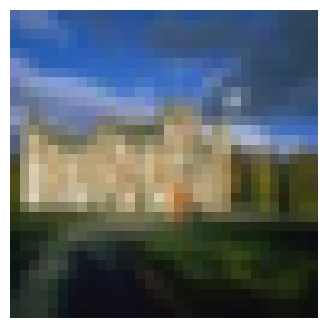

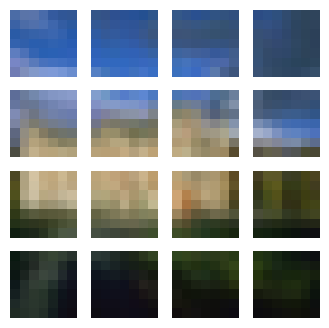

In [6]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [7]:
# ViT model for image classification
def ViT():
    inputs = keras.Input(shape=input_shape)
    # Augment data
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head self-attention mechanism.
        attention_output = keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = keras.layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = keras.layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = keras.layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = keras.layers.Flatten()(representation)
    representation = keras.layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = keras.layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [8]:
model = ViT()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 data_augmentation (Sequential)  (None, 28, 28, 3)   7           ['input_1[0][0]']                
                                                                                                  
 patches_1 (Patches)            (None, 16, 147)      0           ['data_augmentation[0][0]']      
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 16, 64)       10496       ['patches_1[0][0]']              
                                                                                              

**Training Function**

In [13]:
import tensorflow as tf
from tensorflow import keras
import os

# 🔹 Set memory growth BEFORE initializing any TensorFlow/Keras objects
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print(f"Failed to set memory growth: {e}")

# 🔹 Enable mixed precision for better performance (optional)
tf.keras.mixed_precision.set_global_policy("mixed_float16")

def run_experiment(model, device="/GPU:0"):
    # Ensure GPU usage is visible in logs
    tf.debugging.set_log_device_placement(True)

    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)

    try:
        with tf.device(device):  # Set computation device
            model.compile(
                optimizer=optimizer,
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[
                    keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                    keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
                ],
            )

            # Create checkpoint directory if it doesn't exist
            checkpoint_dir = "checkpoints"
            os.makedirs(checkpoint_dir, exist_ok=True)
            checkpoint_filepath = os.path.join(checkpoint_dir, "vit_tf_model")

            # Callbacks for checkpointing & early stopping
            checkpoint_callback = keras.callbacks.ModelCheckpoint(
                filepath=checkpoint_filepath,
                monitor="val_accuracy",
                save_best_only=True,
                save_weights_only=False,  # Save full model
                mode="max",
                verbose=1,
            )

            early_stopping = keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=5,  # Stop training if no improvement for 5 epochs
                restore_best_weights=True
            )

            # Train the model
            history = model.fit(
                x=x_train,
                y=y_train,
                batch_size=batch_size,
                epochs=num_epochs,
                validation_split=0.1,
                callbacks=[checkpoint_callback, early_stopping],
            )

            # Load best model
            model.load_weights(checkpoint_filepath)

            # Evaluate the model
            _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
            print(f"Test accuracy: {round(accuracy * 100, 2)}%")
            print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

            return history

    except Exception as e:
        print(f"Error during training: {str(e)}")
        return None


Failed to set memory growth: Physical devices cannot be modified after being initialized


In [ ]:
# Enable logging for device placement
tf.debugging.set_log_device_placement(True)

# Check available GPUs
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPU Details:", tf.config.list_physical_devices('GPU'))

DEVICE = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
print(f"Using device: {DEVICE}")

vit_classifier = ViT()
history = run_experiment(vit_classifier, device=DEVICE)


def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("top-5-accuracy")